# Regularization in Regression Analysis: LASSO for Asset Pricing Factor Models

In this example, we explore **LASSO (Least Absolute Shrinkage and Selection Operator)**, a popular regularization technique used in regression analysis. LASSO is particularly useful in **asset pricing models** where numerous potential factors, often referred to as the "factor zoo," can lead to overfitting and reduce model interpretability.

### What is LASSO?
LASSO is a type of linear regression that applies an \( L_1 \) penalty to the regression coefficients. This penalty term encourages the model to shrink less important factor coefficients to zero, effectively selecting only the most relevant factors. This feature selection quality is highly valuable in asset pricing, as it helps to:
- **Reduce Model Complexity**: By eliminating unimportant factors, LASSO produces simpler, more interpretable models.
- **Mitigate Overfitting**: Regularization helps avoid overfitting, especially when working with a large number of correlated factors.
- **Improve Out-of-Sample Prediction**: LASSO enhances the model's predictive accuracy on new data by focusing only on the most influential factors.

### Why Use LASSO in Asset Pricing?
In asset pricing models, researchers often start with a large set of economic and market-based factors. LASSO assists in narrowing down this factor set, identifying the key drivers of asset returns while ignoring noise. By using LASSO, we can build more robust models that provide clearer insights into which factors are truly influencing asset prices.

In the following cells, we'll implement LASSO on an asset pricing dataset to see how it performs in feature selection, focusing on model accuracy and factor relevance.


In [13]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LassoCV

## Set up necessary functions

In [5]:
def create_market_factors(stock_data):
    """
    Create basic market factors from stock data
    Returns DataFrame with calculated factors
    """
    df = stock_data.copy()
    
    # Calculate daily returns
    df['Return'] = df['Adj Close'].pct_change()
    
    # Calculate volume factors
    df['Volume_Change'] = df['Volume'].pct_change()
    df['Volume_MA_Ratio'] = df['Volume'] / df['Volume'].rolling(window=20).mean()
    
    # Calculate price momentum factors
    df['Mom_1M'] = df['Adj Close'].pct_change(periods=21)
    df['Mom_3M'] = df['Adj Close'].pct_change(periods=63)
    df['Mom_6M'] = df['Adj Close'].pct_change(periods=126)
    
    # Calculate volatility factors
    df['Volatility_1M'] = df['Return'].rolling(window=21).std()
    df['Volatility_3M'] = df['Return'].rolling(window=63).std()
    
    # Calculate moving average factors
    df['MA_10'] = df['Adj Close'].rolling(window=10).mean()
    df['MA_50'] = df['Adj Close'].rolling(window=50).mean()
    df['MA_Ratio'] = df['MA_10'] / df['MA_50'] - 1
    
    # Calculate RSI
    delta = df['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    return df

def prepare_stock_data(ticker, start_date, end_date):
    """
    Download and prepare stock data with factors
    Returns DataFrame with stock data and calculated factors
    """
    # Download stock data
    stock = yf.download(ticker, start=start_date, end=end_date)
    
    # Calculate factors
    stock_with_factors = create_market_factors(stock)
    
    # Download market data (S&P 500 as market proxy)
    market = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']
    market_return = market.pct_change()
    
    # Calculate market-related factors
    stock_with_factors['Market_Return'] = market_return
    stock_with_factors['Beta'] = (
        stock_with_factors['Return']
        .rolling(window=252)
        .cov(market_return) / market_return.rolling(window=252).var()
    )
    
    return stock_with_factors

def create_factor_model(ticker='AAPL', lookback_days=252, prediction_days=21):
    """
    Create and analyze factor model using LASSO regression
    """
    # Set dates
    end_date = datetime.now()
    start_date = end_date - timedelta(days=lookback_days + 252)  # Extra days for calculations
    
    # Get stock data with factors
    data = prepare_stock_data(ticker, start_date, end_date)
    
    # Create target: forward returns
    data['Forward_Return'] = data['Return'].shift(-prediction_days)
    
    # Select features
    feature_columns = [
        'Return', 'Volume_Change', 'Volume_MA_Ratio',
        'Mom_1M', 'Mom_3M', 'Mom_6M',
        'Volatility_1M', 'Volatility_3M',
        'MA_Ratio', 'RSI', 'Market_Return', 'Beta'
    ]
    
    # Create lagged features
    lags = [1, 5, 21]  # Daily, weekly, monthly lags
    for factor in feature_columns:
        for lag in lags:
            data[f'{factor}_lag_{lag}'] = data[factor].shift(lag)
    
    # Clean data
    data = data.dropna()
    
    # Prepare features and target
    y = data['Forward_Return']
    X = data.drop(['Forward_Return', 'Adj Close', 'Close', 'Open', 'High', 'Low', 'Volume'] + 
                 feature_columns, axis=1)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    
    return X_scaled, y, data

def perform_lasso_analysis(X, y, alphas=np.logspace(-4, 1, 50)):
    """
    Perform LASSO analysis with different regularization parameters
    Returns coefficients for each alpha
    """
    coef_paths = pd.DataFrame(index=X.columns)
    
    for alpha in alphas:
        lasso = Lasso(alpha=alpha, max_iter=10000)
        lasso.fit(X, y)
        coef_paths[f'alpha_{alpha:.6f}'] = lasso.coef_
    
    return coef_paths

def plot_lasso_paths(coef_paths, alphas):
    """
    Plot LASSO coefficient paths
    """
    plt.figure(figsize=(15, 8))
    for feature in coef_paths.index:
        plt.plot(np.log10(alphas), coef_paths.T.values, '-', lw=1)
    
    plt.xlabel('log(alpha)')
    plt.ylabel('Coefficients')
    plt.title('LASSO Coefficient Paths')
    plt.grid(True, alpha=0.3)
    
    # Add a legend for the most important features
    important_features = coef_paths.loc[
        coef_paths.abs().mean(axis=1).nlargest(10).index
    ]
    for feature in important_features.index:
        plt.plot(np.log10(alphas), coef_paths.loc[feature], '-', lw=2, label=feature)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    return plt

def compare_models(X, y, alpha):
    """
    Compare OLS and LASSO models
    """
    # OLS
    ols = LinearRegression()
    ols.fit(X, y)
    ols_coef = pd.Series(ols.coef_, index=X.columns)
    
    # LASSO with moderate regularization
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    lasso_coef = pd.Series(lasso.coef_, index=X.columns)
    
    # Compare coefficients
    comparison = pd.DataFrame({
        'OLS': ols_coef,
        'LASSO': lasso_coef
    })
    
    comparison['Selected_by_LASSO'] = comparison['LASSO'] != 0
    comparison = comparison.sort_values('LASSO', key=abs, ascending=False)
    
    return comparison

## Perform LASSO analysis

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


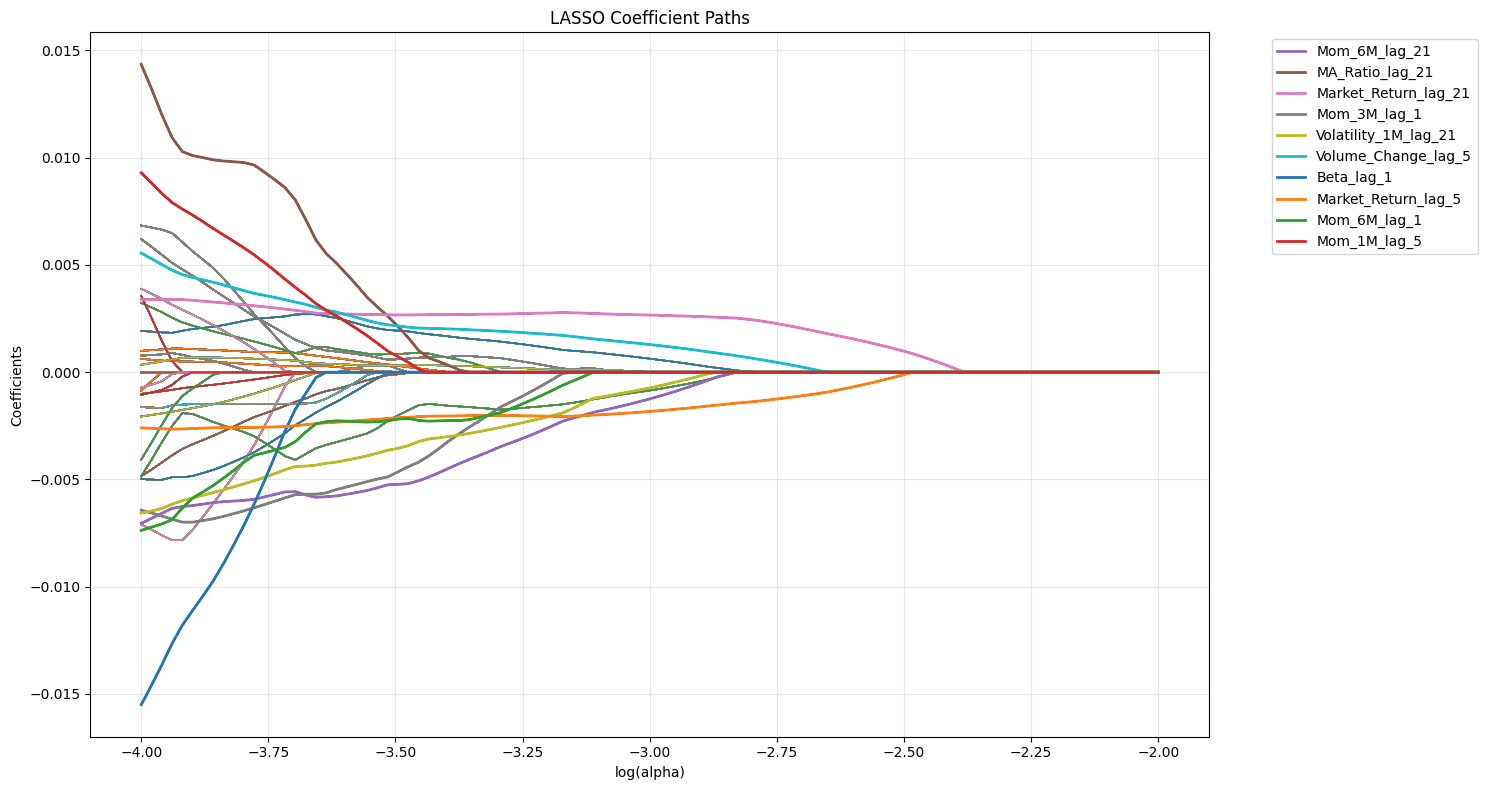

In [8]:
# Set parameters
ticker = 'AAPL'
lookback_days = 252  # One year of trading days
prediction_days = 21  # One month forward returns

# Prepare data
X, y, data = create_factor_model(ticker, lookback_days, prediction_days)

# Perform LASSO analysis
alphas = np.logspace(-4, -2, 100)
coef_paths = perform_lasso_analysis(X, y, alphas)

# Plot LASSO paths
plt_paths = plot_lasso_paths(coef_paths, alphas)
plt_paths.show()

## Comparing OLS and LASSO Regression with a Specific Alpha Value

In this section, we compare **Ordinary Least Squares (OLS)** regression with **LASSO** regression for a specific alpha value, selected to balance model simplicity and predictive accuracy.

### Why Compare OLS and LASSO?
- **OLS**: Ordinary Least Squares regression is a traditional approach that minimizes the sum of squared residuals to fit a model. However, when dealing with a large number of features, OLS can overfit, especially if some features add noise rather than valuable information.
- **LASSO**: Unlike OLS, LASSO (Least Absolute Shrinkage and Selection Operator) applies an \( L_1 \) penalty, shrinking less important feature coefficients to zero. This makes LASSO a valuable feature selection tool, helping to reduce overfitting by retaining only the most impactful features.

### Selecting the Alpha Parameter for LASSO
The **alpha** parameter in LASSO controls the strength of the regularization:
- **Higher alpha** values result in more aggressive shrinking of coefficients, potentially leading to a simpler model but with fewer retained features.
- **Lower alpha** values retain more features but may introduce overfitting by including less relevant variables.

We often select alpha from a range of values in log space (e.g., \(10^{-3}\) to \(10^{0}\)) because:
- **Log space** allows for efficient exploration** across magnitudes, helping to identify the optimal level of regularization.
- By plotting alpha values in log space, we capture a wider range of regularization strengths, making it easier to find the best balance between bias (fit accuracy) and variance (model complexity).

In this comparison, we’ll evaluate OLS and LASSO using an alpha of \(10^{-2.75}\), examining their fit to the data and their ability to handle feature selection in the asset pricing context.


In [11]:
# Compare models
comparison = compare_models(X, y, 10**(-2.75))
print("\nFeature Selection Comparison (top features by LASSO coefficient magnitude):")
print(comparison.head(10))

# Print selected features
selected_features = comparison[comparison['Selected_by_LASSO']].index
print(f"\nNumber of features selected by LASSO: {len(selected_features)}")
print("\nTop 10 most important features selected by LASSO:")
print(selected_features[:10].tolist())


Feature Selection Comparison (top features by LASSO coefficient magnitude):
                           OLS     LASSO  Selected_by_LASSO
Market_Return_lag_21  0.004004  0.002265               True
Market_Return_lag_5  -0.003758 -0.001252               True
Volume_Change_lag_5   0.012836  0.000457               True
Return_lag_1         -0.002024  0.000000              False
MA_10                 0.032838 -0.000000              False
MA_50                -0.094190  0.000000              False
Volume_Change_lag_1  -0.000392 -0.000000              False
Return_lag_21         0.004641  0.000000              False
Return_lag_5          0.000864 -0.000000              False
Volume_Change_lag_21 -0.000465 -0.000000              False

Number of features selected by LASSO: 3

Top 10 most important features selected by LASSO:
['Market_Return_lag_21', 'Market_Return_lag_5', 'Volume_Change_lag_5']


# Advanced LASSO Analysis: Feature Importance, Cross-Validation, and Model Evaluation

In this section, we expand our LASSO regression analysis with additional tools to gain deeper insights into the model’s performance and feature selection capabilities. These steps are designed to evaluate and compare LASSO’s effectiveness in capturing the most relevant factors in asset pricing while balancing predictive accuracy and model simplicity.

### Key Components of the Advanced Analysis

1. **Feature Importance and Correlation Heatmap**:
    - The `plot_feature_importance_heatmap` function identifies the top features by their absolute LASSO coefficients and visualizes their relationships.
    - It includes two key plots:
      - **Feature Correlations**: A heatmap showing correlations between the top features, helping to understand multicollinearity.
      - **LASSO Coefficients vs Target Correlation**: A scatter plot displaying each feature’s correlation with the target variable alongside its LASSO coefficient.
    - *Purpose*: This step helps us identify which features LASSO prioritizes and assesses whether these features have a meaningful correlation with the target. It provides insight into LASSO's feature selection, especially when dealing with many potentially correlated variables.

2. **Comparing OLS and LASSO Models**:
    - The `compare_models` function contrasts OLS and LASSO by comparing their respective coefficients. It highlights which features LASSO keeps or discards by setting smaller coefficients to zero.
    - *Purpose*: By comparing OLS (unregularized) and LASSO (regularized), we can see how LASSO enhances interpretability by selecting only the most impactful features, avoiding overfitting in models with many factors.

3. **Cross-Validated Alpha Path for LASSO**:
    - The `plot_cv_path` function performs cross-validation over a range of alpha values to determine the optimal regularization level.
    - Two plots are generated:
      - **MSE vs. Alpha**: Plots Mean Squared Error (MSE) against different alpha values with confidence intervals. The chosen alpha minimizes MSE, balancing fit quality and regularization.
      - **Feature Count vs. Alpha**: Shows the number of non-zero coefficients at each alpha level, illustrating how regularization affects feature selection.
    - *Purpose*: This analysis provides a robust approach to selecting the optimal alpha value by balancing predictive accuracy and model complexity. The cross-validation approach ensures that the model performs well on unseen data.

4. **Predictions Analysis and Residual Diagnostics**:
    - The `plot_predictions_analysis` function evaluates model predictions using actual vs. predicted plots, residual distributions, and QQ plots.
    - Key plots include:
      - **Actual vs. Predicted**: Shows the alignment between predicted and actual values, along with metrics such as \(R^2\) and RMSE.
      - **Residuals Distribution**: Helps assess whether residuals are centered around zero, indicating a well-fitted model.
      - **Normal Q-Q Plot**: Checks the normality of residuals, providing insight into model assumptions.
    - *Purpose*: This final step ensures that the LASSO model not only fits well but also meets key assumptions, such as normality in residuals, which enhances confidence in the model’s validity.

### Insights from Advanced LASSO Analysis
- **Feature Selection**: LASSO’s ability to discard unimportant features helps prevent overfitting, especially in models with many factors.
- **Optimal Regularization**: Cross-validated alpha selection helps in choosing a balance between model accuracy and simplicity.
- **Model Performance**: Visualization of residuals and predicted values ensures that the model predictions are reliable, enabling informed decisions in asset pricing and investment.

This advanced LASSO analysis enables us to refine our model by focusing on the most predictive factors, using regularization effectively, and validating the model's robustness with cross-validation and residual analysis.


In [16]:
def plot_feature_importance_heatmap(comparison, data, target, n_features=20):
    """
    Create a heatmap showing feature correlations and LASSO coefficients
    """
    # Select top features by absolute LASSO coefficient
    comparison['LASSO_abs'] = comparison['LASSO'].abs()
    top_features = comparison.nlargest(n_features, 'LASSO_abs').index
    
    # Create correlation matrix for top features
    feature_data = data[top_features]
    corr_matrix = feature_data.corrwith(target).to_frame()
    corr_matrix.columns = ['Correlation with Target']
    corr_matrix['LASSO Coefficient'] = comparison.loc[top_features, 'LASSO']
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot feature correlations heatmap
    feature_corr = feature_data.corr()
    sns.heatmap(feature_corr, ax=ax1, cmap='RdBu', center=0,
                annot=True, fmt='.2f', square=True)
    ax1.set_title('Feature Correlations')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)
    
    # Plot LASSO coefficients vs correlations
    sns.scatterplot(data=corr_matrix, x='Correlation with Target', 
                   y='LASSO Coefficient', ax=ax2)
    for idx, row in corr_matrix.iterrows():
        ax2.annotate(idx, (row['Correlation with Target'], row['LASSO Coefficient']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    ax2.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    ax2.axvline(x=0, color='r', linestyle='--', alpha=0.3)
    ax2.set_title('LASSO Coefficients vs Target Correlation')
    
    plt.tight_layout()
    return fig

def compare_models(X, y, alpha=0.01):
    """
    Compare OLS and LASSO models
    """
    # OLS
    ols = LinearRegression()
    ols.fit(X, y)
    ols_coef = pd.Series(ols.coef_, index=X.columns)
    
    # LASSO with specified alpha
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    lasso_coef = pd.Series(lasso.coef_, index=X.columns)
    
    # Compare coefficients
    comparison = pd.DataFrame({
        'OLS': ols_coef,
        'LASSO': lasso_coef
    })
    
    comparison['Selected_by_LASSO'] = comparison['LASSO'] != 0
    # Add absolute values for sorting
    comparison['LASSO_abs'] = comparison['LASSO'].abs()
    comparison = comparison.sort_values('LASSO_abs', ascending=False)
    comparison = comparison.drop('LASSO_abs', axis=1)
    
    return comparison

def plot_cv_path(X, y, n_splits=5):
    """
    Plot cross-validated LASSO path with confidence intervals
    """
    # Create time series cross-validation object
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Fit LassoCV
    alphas = np.logspace(-4, 1, 50)
    lasso_cv = LassoCV(alphas=alphas, cv=tscv, max_iter=10000)
    lasso_cv.fit(X, y)
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot MSE vs alpha
    ax1.plot(np.log10(lasso_cv.alphas_), lasso_cv.mse_path_.mean(axis=1))
    ax1.fill_between(np.log10(lasso_cv.alphas_),
                     lasso_cv.mse_path_.mean(axis=1) - lasso_cv.mse_path_.std(axis=1),
                     lasso_cv.mse_path_.mean(axis=1) + lasso_cv.mse_path_.std(axis=1),
                     alpha=0.2)
    ax1.axvline(np.log10(lasso_cv.alpha_), color='r', linestyle='--')
    ax1.set_xlabel('log(alpha)')
    ax1.set_ylabel('Mean Squared Error')
    ax1.set_title('Cross-validated MSE vs alpha')
    
    # Plot number of features vs alpha
    coef_path = np.array([Lasso(alpha=alpha).fit(X, y).coef_ for alpha in lasso_cv.alphas_])
    ax2.plot(np.log10(lasso_cv.alphas_), np.sum(coef_path != 0, axis=1))
    ax2.axvline(np.log10(lasso_cv.alpha_), color='r', linestyle='--')
    ax2.set_xlabel('log(alpha)')
    ax2.set_ylabel('Number of non-zero coefficients')
    ax2.set_title('Feature Count vs alpha')
    
    plt.tight_layout()
    return fig, lasso_cv

def plot_predictions_analysis(X, y, lasso_cv):
    """
    Plot actual vs predicted values and residual analysis
    """
    # Make predictions
    y_pred = lasso_cv.predict(X)
    
    # Calculate metrics
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    # Create figure with three subplots
    fig = plt.figure(figsize=(20, 6))
    gs = plt.GridSpec(1, 3)
    
    # Actual vs Predicted scatter plot
    ax1 = fig.add_subplot(gs[0])
    ax1.scatter(y, y_pred, alpha=0.5)
    ax1.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    ax1.set_xlabel('Actual Returns')
    ax1.set_ylabel('Predicted Returns')
    ax1.set_title(f'Actual vs Predicted\nR² = {r2:.3f}, RMSE = {rmse:.3f}')
    
    # Residuals histogram
    ax2 = fig.add_subplot(gs[1])
    residuals = y - y_pred
    sns.histplot(residuals, kde=True, ax=ax2)
    ax2.set_xlabel('Residuals')
    ax2.set_title('Residuals Distribution')
    
    # QQ plot
    ax3 = fig.add_subplot(gs[2])
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=ax3)
    ax3.set_title('Normal Q-Q Plot')
    
    plt.tight_layout()
    return fig

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


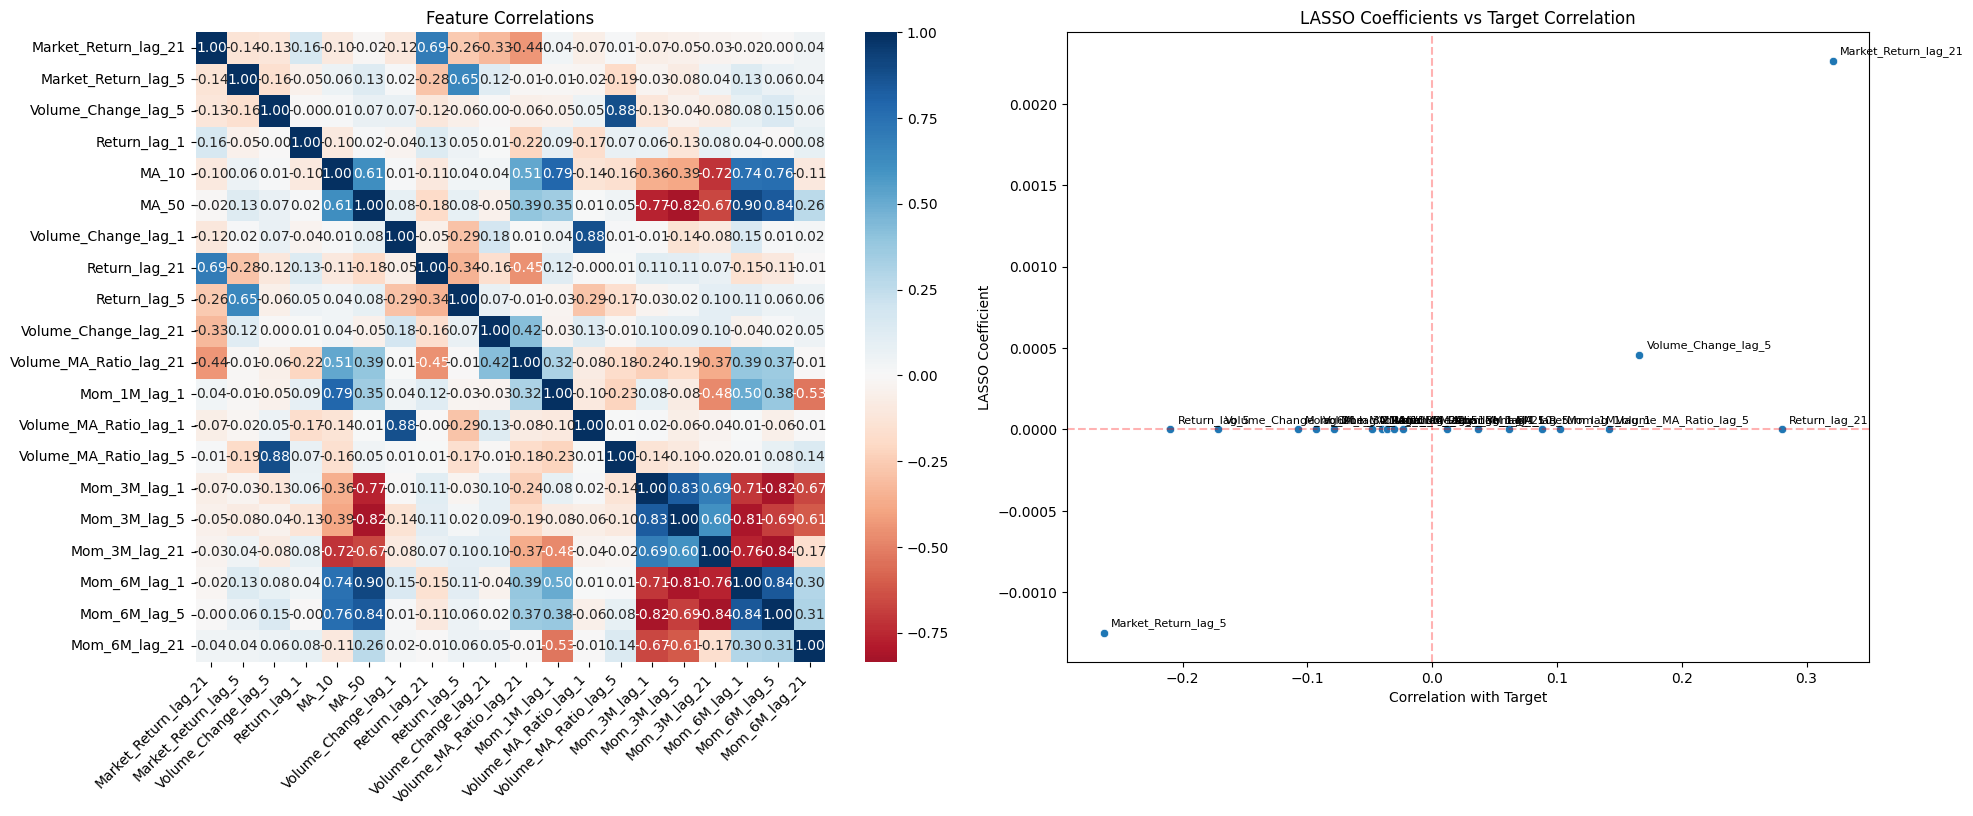

/home/c47e0470-b83d-48c6-a026-413daab4c753/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.876e-06, tolerance: 9.045e-07
  model = cd_fast.enet_coordinate_descent(


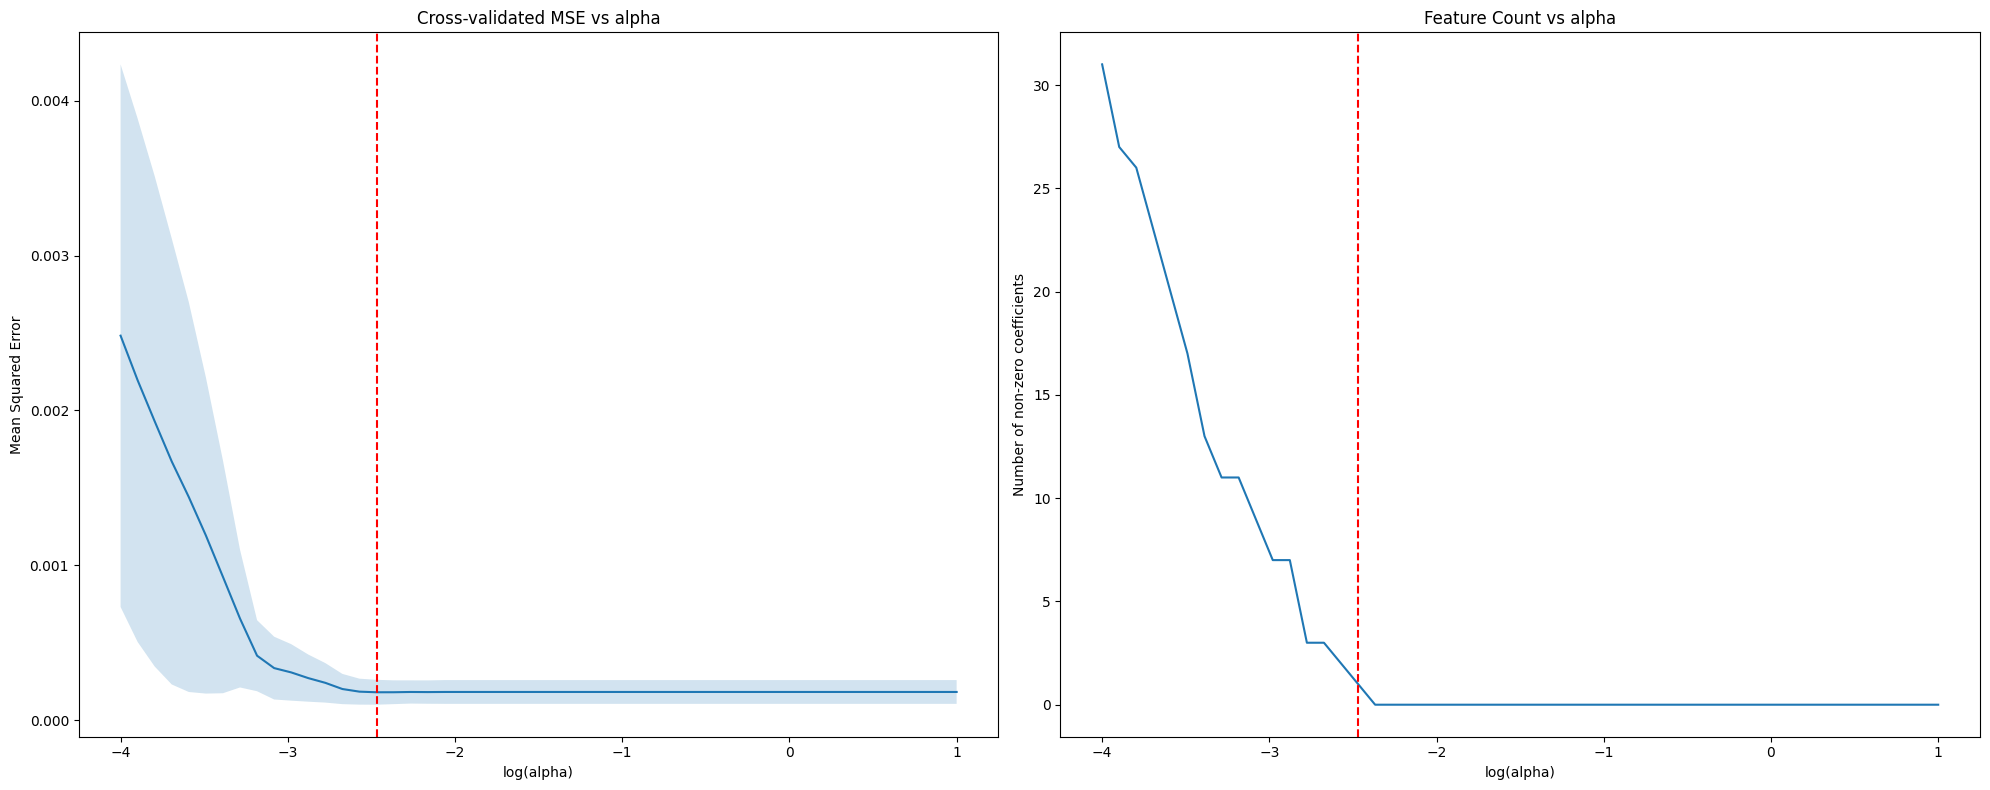

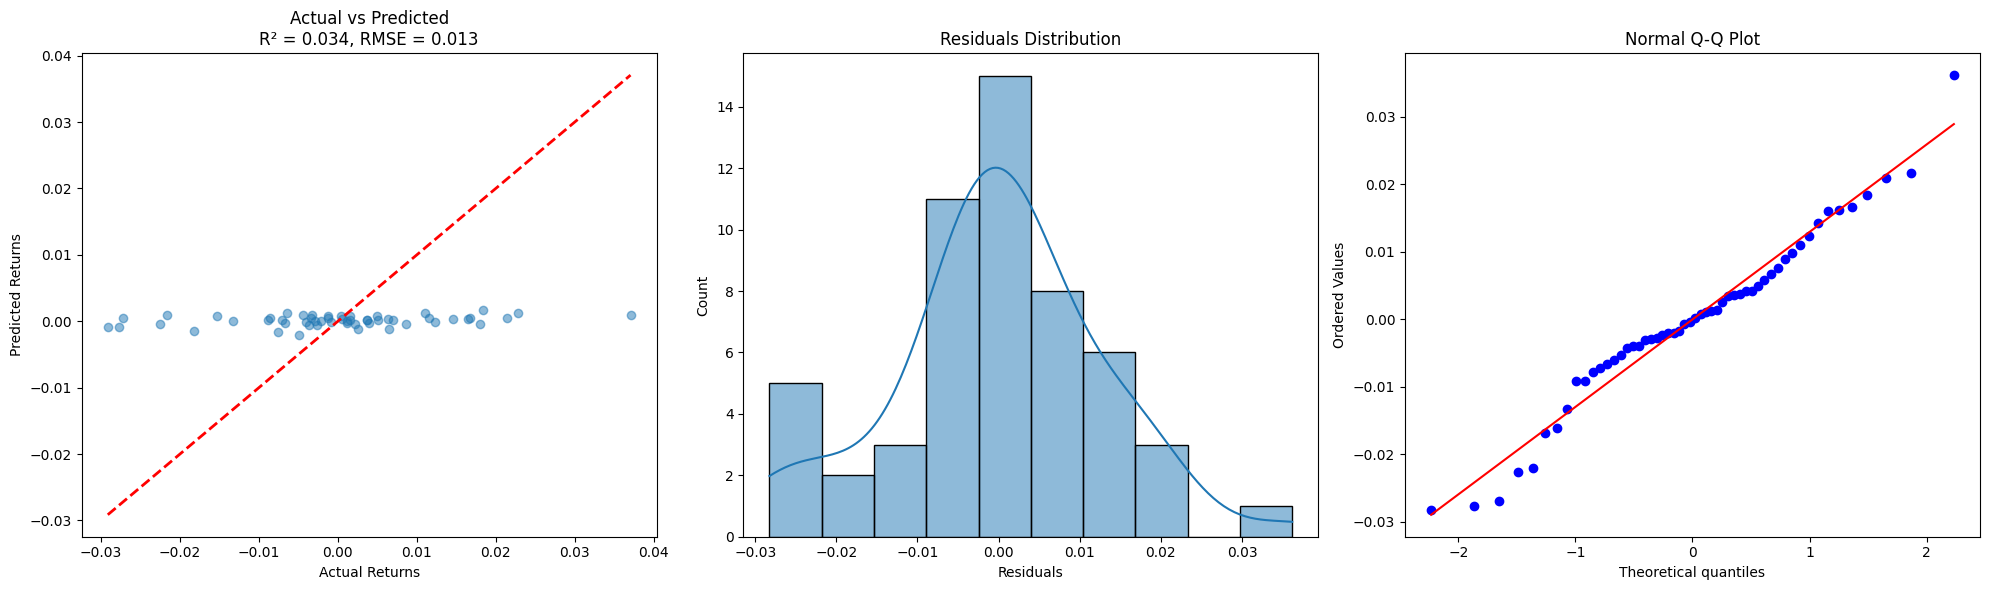

In [18]:
# Get data using previous code
X, y, data = create_factor_model()

# Create and display all visualizations

# 1. Feature importance heatmap
comparison = compare_models(X, y, alpha=10**(-2.75))
fig_heatmap = plot_feature_importance_heatmap(comparison, X, y)
plt.show()

# 2. Cross-validation analysis
fig_cv, lasso_cv = plot_cv_path(X, y)
plt.show()

# 3. Predictions analysis
fig_pred = plot_predictions_analysis(X, y, lasso_cv)
plt.show()
